<a href="https://colab.research.google.com/github/AliceKitchkin/Forecasting-Rossmann-Store-Sales/blob/main/Forecasting_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vorhersagen von Rossmann Store Sales

## Inhaltsverzeichnis <a id="0"></a> <br>
1. [Einleitung](#1) <font color='green'>Alice</font>  
2. [Package- und Datenimport](#2) <font color='green'>Alice</font>  
3. [Deskriptive Analyse](#3) <font color='green'></font>  
    3.1 [Datenüberblick](#3.1) <font color='green'>Alice</font>  
    3.2 [Datentypen](#3.2) <font color='orange'>Alice</font>  
    3.3 [Betrachtung der Verteilung](#3.3) <font color='orange'>Alice</font>  
    3.4 [Analyse der Kategorischen Variablen](#3.4) <font color='red'>Niklas</font>  
    3.5 [Fehlende Werte](#3.5) <font color='red'>Niklas</font>  
    3.6 [Ausreißer](#3.6) <font color='red'>Niklas</font>  
    3.7 [Zeitreihenanalyse](#3.7) <font color='green'>Niklas</font>  
    3.8 [Korrelationen](#3.8) <font color='orange'>Alice</font>
4. [Daten anpassen](#4) <font color='red'>Not started</font>  
5. [Geeignete Merkmale](#4) <font color='red'>Not started</font>  
6. [ML Verfahren 1](#5) <font color='red'>Not started</font>  
7. [ML Verfahren 2](#6) <font color='red'>Not started</font>  
8. [Vergleich](#7) <font color='red'>Not started</font>  

## 1. Einleitung <a id="1"></a> <br>

Dieses Jupyter Notebook dokumentiert unser Projekt für das Modul Data Mining, in dem wir die Verkaufszahlen der Rossmann-Filialen vorhersagen. Diese Aufgabe basiert auf dem Rossmann Store Sales Datensatz von [Kaggle.com](https://www.kaggle.com/competitions/rossmann-store-sales/overview), der umfangreiche Verkaufsdaten von über 1000 Filialen enthält. 

Alle verwendeten Quellen werden entsprechend referenziert. Die Nutzung von KI-gestützten Tools ist für dieses Projekt erlaubt und alle Schritte, einschließlich der Prompts, werden dokumentiert.

## 2. Package- und Datenimport <a id="2"></a> <br>

In [178]:
import calendar
import locale
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set_style(style='white') # Hintergrund der Plots

In [179]:
# unzip train-file, to large for github
# train.csv is included in .gitignore
with zipfile.ZipFile("./data/train.zip", "r") as zip:
    zip.extract('train.csv', "./data/")

In [180]:
# Maximale Anzahl an Spalten und Zeilen, beim anzeigen von Dataframes
pd.options.display.max_columns = None
pd.options.display.max_rows = 50

## 3. Deskriptive Analyse <a id="3"></a> <br>

Der Rossmann Store Sales-Datensatz enthält historische Verkaufsdaten für 1.115 Rossmann-Filialen. Er besteht aus drei CSV-Dateien:

- train.csv: Historische Daten einschließlich Verkäufe
- test.csv: Historische Daten ohne Verkäufe (für die Vorhersage)
- store.csv: Zusätzliche Informationen über die Filialen

Im ersten Schritt werden die Spalten der Datensätze umbenannt und in Variablen gespeichert.


In [181]:
# Spalten umbennen, damit alles einheitlich auf deutsch ist
train_original = pd.read_csv("./data/train.csv").rename(columns={"Store":"Filiale",
                                                                 "DayOfWeek":"Wochentag",
                                                                 "Date":"Datum",
                                                                 "Sales":"Umsatz",
                                                                 "Customers":"Kundenanzahl",
                                                                 "Open":"Geoeffnet",
                                                                 "Promo":"Aktionstag",
                                                                 "StateHoliday":"Feiertag",
                                                                 "SchoolHoliday":"Schulferien"})

test_original = pd.read_csv("./data/test.csv").rename(columns={"Id":"ID",
                                                                  "Store":"Filiale",
                                                                  "DayOfWeek":"Wochentag",
                                                                  "Date":"Datum",
                                                                  "Open":"Geoeffnet",
                                                                  "Promo":"Aktionstag",
                                                                  "StateHoliday":"Feiertag",
                                                                  "SchoolHoliday":"Schulferien"})

store_original = pd.read_csv("./data/store.csv").rename(columns={"Store":"Filiale",
                                                                  "StoreType":"Filialentyp",
                                                                  "Assortment":"Sortiment",
                                                                  "CompetitionDistance":"Wettbewerberentfernung",
                                                                  "CompetitionOpenSinceMonth":"Wettbewerber_Eroeffnet_seit_Monat",
                                                                  "CompetitionOpenSinceYear":"Wettbewerber_Eroeffnet_seit_Jahr",
                                                                  "Promo2": "Teilnahme_Langzeitaktion",
                                                                  "Promo2SinceWeek":"Aktion_seit_Woche",
                                                                  "Promo2SinceYear":"Aktion_seit_Jahr",
                                                                  "PromoInterval":"Aktionsmonate"})




# Um in einem späteren Zeitpunkt auf die originalen Datensätze zugreifen zu können, werden diese hier separat gespeichert.
# Außerdem werden die Datensätze _train_original_ und _store_original_ über die Spalte _Filiale_ verbunden und im neuen Datensatz 
# _train_x_store_ gespeichert. Für den Datensatz _test_original_ wird das gleiche Prozedere angewandt.
train = train_original
test = test_original
store = store_original

train_x_store = pd.merge(train, store)
test_x_store = pd.merge(test, store)

C:\Users\AliceKitchkin\AppData\Local\Temp\ipykernel_4560\3191597121.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_original = pd.read_csv("./data/train.csv").rename(columns={"Store":"Filiale",


### 3.1 Datenüberblick <a id="3.1"></a> <br>

Kurzbeschreibung der Spalten der Train-, Test- und Store-Datensätze.

| Spalte                        | Umbenennung                           | Beschreibung                                                         |
|-------------------------------|---------------------------------------|----------------------------------------------------------------------|
| `Id`                          | `ID`                                  | Eindeutige ID für jede Filiale und jedes Datumspaar im Testdatensatz.|
| `Store`                       | `Filiale`                             | Eindeutige ID für jede Filiale.|
| `Sales`                       | `Wochentag`                           | Wochentag als Zahl von 1 (Montag) bis 7 (Sonntag) |
| `Date`                        | `Datum`                               | Datum (im "yyyy-mm-dd" Format) |
| `Sales`                       | `Umsatz`                              | Umsatz an einem bestimmten Tag (zu prognostizierendes Ziel).|
| `Customers`                   | `Kundenanzahl`                        | Anzahl der Kunden an einem bestimmten Tag.|
| `Open`                        | `Geoeffnet`                           | Indikator, ob die Filiale geöffnet war (0 = geschlossen, 1 = geöffnet).|
| `Promo`                       | `Aktionstag`                          | Gibt an, ob ein Geschäft an diesem Tag eine Werbeaktion durchführt.|
| `StateHoliday`                | `Feiertag`                            | Feiertagstyp (a = öffentlicher Feiertag, b = Osterfeiertag, c = Weihnachten, 0 = keiner).|
| `SchoolHoliday`               | `Schulferien`                         | Gibt an, ob die Filiale von Schulschließungen betroffen war.|
| `StoreType`                   | `Filialtyp`                           | Unterscheidet zwischen 4 verschiedenen Filialmodellen (a, b, c, d).|
| `Assortment`                  | `Sortiment`                           | Beschreibt das Sortiment (a = grundlegend, b = extra, c = erweitert).|
| `CompetitionDistance`         | `Wettbewerberentfernung`              | Entfernung in Metern zum nächsten Wettbewerbergeschäft.|
| `CompetitionOpenSinceMonth`   | `Wettbewerber_Eroeffnet_seit_Monat`   | Gibt den Monat an, in dem der nächste Wettbewerber eröffnet wurde.|
| `CompetitionOpenSinceYear`    | `Wettbewerber_Eroeffnet_seit_Jahr`    | Gibt das Jahr an, in dem der nächste Wettbewerber eröffnet wurde.|
| `Promo2`                      | `Teilnahme_Langzeitaktion`            | Promo2 ist eine fortlaufende und aufeinanderfolgende Werbeaktion für einige Geschäfte (0 = nein, 1 = ja).|
| `Promo2SinceWeek`             | `Aktion_seit_Woche`                   | Beschreibt die Kalenderwoche, in der das Geschäft an Promo2 teilnimmt.|
| `Promo2SinceYear`             | `Aktion_seit_Jahr`                    | Beschreibt das Jahr, in der das Geschäft an Promo2 teilnimmt.|
| `PromoInterval`               | `Aktionsmonate`                       | Beschreibt die aufeinanderfolgenden Intervalle, in denen Promo2 gestartet wird (z. B. "Feb, Mai, Aug, Nov").|

**Train-Datensatz Datenüberblick**

In [182]:
display(train.head())

,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


**Test-Datensatz Datenüberblick**

In [183]:
display(test.head())

,ID,Filiale,Wochentag,Datum,Geoeffnet,Aktionstag,Feiertag,Schulferien
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


**Store-Datensatz Datenüberblick**

In [184]:
display(store.head())

,Filiale,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### 3.2 Datentypen <a id="3.2"></a> <br>

Neue Spalten
| Originale Spalte              | Neue Spalte                           | Beschreibung                                                              |
|-------------------------------|---------------------------------------|---------------------------------------------------------------------------|
| `Datum`                          | `Tag`                              | Gibt den Tag aus der ursprünglichen Spalte Datum an (von 1 bis 31).       |
| `Datum`                          | `Monat`                            | Gibt den Monat aus der ursprünglichen Spalte Datum an (von 1 bis 12).     |
| `Datum`                          | `Jahr`                             | Gibt das Jahr aus der ursprünglichen Spalte Datum an.             	    |
| `Datum`                          | `Quartal`                          | Gibt das Quartal aus der ursprünglichen Spalte Datum an (von 1 bis 4).    |

In [185]:
# Datentypen vor Korrektur
train_x_store.dtypes

Filiale                                int64
Wochentag                              int64
Datum                                 object
Umsatz                                 int64
Kundenanzahl                           int64
Geoeffnet                              int64
Aktionstag                             int64
Feiertag                              object
Schulferien                            int64
Filialentyp                           object
Sortiment                             object
Wettbewerberentfernung               float64
Wettbewerber_Eroeffnet_seit_Monat    float64
Wettbewerber_Eroeffnet_seit_Jahr     float64
Teilnahme_Langzeitaktion               int64
Aktion_seit_Woche                    float64
Aktion_seit_Jahr                     float64
Aktionsmonate                         object
dtype: object

In [186]:
# bestehende Spalten anpassen
train_x_store["Datum"] = pd.to_datetime(train_x_store["Datum"])
train_x_store["Wochentag"] = train_x_store["Datum"].dt.weekday

neue_spalten = {
    "Tag": train_x_store["Datum"].dt.day,
    "Monat": train_x_store["Datum"].dt.month,
    "Jahr": train_x_store["Datum"].dt.year,
    "Quartal": train_x_store["Datum"].dt.quarter
}

# Dataframe teilen, um die neuen Spalten in gewünschter Reihenfolge einzufügen
train_x_store_before = train_x_store.iloc[:, :1]
train_x_store_after = train_x_store.iloc[:, 1:]

# Alten Dataframe mit den neuen Spalten zusammenführen
train_x_store = pd.concat([train_x_store_before, pd.DataFrame(neue_spalten), train_x_store_after], axis=1)

In [187]:
# Datentypen nach Korrektur
display(train_x_store.dtypes)

Filiale                                       int64
Tag                                           int32
Monat                                         int32
Jahr                                          int32
Quartal                                       int32
Wochentag                                     int32
Datum                                datetime64[ns]
Umsatz                                        int64
Kundenanzahl                                  int64
Geoeffnet                                     int64
Aktionstag                                    int64
Feiertag                                     object
Schulferien                                   int64
Filialentyp                                  object
Sortiment                                    object
Wettbewerberentfernung                      float64
Wettbewerber_Eroeffnet_seit_Monat           float64
Wettbewerber_Eroeffnet_seit_Jahr            float64
Teilnahme_Langzeitaktion                      int64
Aktion_seit_

### 3.3 Betrachtung der Verteilung <a id="3.3"></a> <br>

- Deskriptive Statistiken: Mittelwert, Median, Minimum, Maximum, Standardabweichung, Quartile (für numerische Variablen).
- Verteilung der Daten: Histogramme, Boxplots oder Dichteplots zur Visualisierung der Verteilung der numerischen Variablen.

In [188]:
describe = round(train_x_store.describe(include='all'), 3)
dtypes = pd.DataFrame(test.dtypes, columns=["dtypes"]).T
display(pd.concat([dtypes, describe]))

,ID,Filiale,Wochentag,Datum,Geoeffnet,Aktionstag,Feiertag,Schulferien,Tag,Monat,Jahr,Quartal,Umsatz,Kundenanzahl,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate
dtypes,int64,int64,int64,object,float64,int64,object,int64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
count,NaN,1017209.0,1017209.0,1017209,1017209.0,1017209.0,1017209,1017209.0,1017209.000,1017209.000,1017209.000,1017209.000,1017209.000,1017209.000,1017209,1017209,1014567.000,693861.000,693861.000,1017209.000,509178.000,509178.000,509178
unique,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a,a,NaN,NaN,NaN,NaN,NaN,NaN,"Jan,Apr,Jul,Oct"
freq,NaN,NaN,NaN,NaN,NaN,NaN,855087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,551627,537445,NaN,NaN,NaN,NaN,NaN,NaN,293122
mean,NaN,558.43,2.998,2014-04-11 01:30:42.846061824,0.83,0.382,NaN,0.179,15.703,5.847,2013.832,2.294,5773.819,633.146,NaN,NaN,5430.086,7.223,2008.690,0.501,23.269,2011.753,NaN
min,NaN,1.0,0.0,2013-01-01 00:00:00,0.0,0.0,NaN,0.0,1.000,1.000,2013.000,1.000,0.000,0.000,NaN,NaN,20.000,1.000,1900.000,0.000,1.000,2009.000,NaN
25%,NaN,280.0,1.0,2013-08-17 00:00:00,1.0,0.0,NaN,0.0,8.000,3.000,2013.000,1.000,3727.000,405.000,NaN,NaN,710.000,4.000,2006.000,0.000,13.000,2011.000,NaN
50%,NaN,558.0,3.0,2014-04-02 00:00:00,1.0,0.0,NaN,0.0,16.000,6.000,2014.000,2.000,5744.000,609.000,NaN,NaN,2330.000,8.000,2010.000,1.000,22.000,2012.000,NaN
75%,NaN,838.0,5.0,2014-12-12 00:00:00,1.0,1.0,NaN,0.0,23.000,8.000,2014.000,3.000,7856.000,837.000,NaN,NaN,6890.000,10.000,2013.000,1.000,37.000,2013.000,NaN


### 3.4 Analyse der kategorischen Variablen <a id="3.4"></a> <br>

tbd

### 3.5 Fehlende Werte<a id="3.5"></a> <br>

In diesem Kapitel identifizieren wir fehlende Werte und Ausreißer in den Daten an. Ausreißer definieren wir als ungegwöhnlich hohe oder niedrige Werte, die nicht dem allgemeinen Muster folgen.

In [189]:
missing_data_abs = train_x_store.isnull().sum()
missing_data_per = ( round(train_x_store.isnull().sum()/train_x_store.shape[0]*100, 2)).apply(lambda x: f"{x}%")

missing_data_table = pd.DataFrame({
    "Fehlende Werte (absolut)": missing_data_abs,
    "Fehlende Werte (prozentual)": missing_data_per
})

display(missing_data_table)

,Fehlende Werte (absolut),Fehlende Werte (prozentual)
Filiale,0,0.0%
Tag,0,0.0%
Monat,0,0.0%
Jahr,0,0.0%
Quartal,0,0.0%
Wochentag,0,0.0%
Datum,0,0.0%
Umsatz,0,0.0%
Kundenanzahl,0,0.0%
Geoeffnet,0,0.0%


#### Fehlende Werte in Wettbewerberentfernung

Im Datensatz gibt es einige Spalten mit fehlenden Werten, welche wir uns nach und nach ansehen werden. Wir beginnen mit der Spalte _Wettbewerberentfernung_, worin 2.642 NaN-Werte gefunden wurden.

In [190]:
train_x_store[pd.isnull(train_x_store.Wettbewerberentfernung)].head()

,Filiale,Tag,Monat,Jahr,Quartal,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate
263244,291,31,7,2015,3,4,2015-07-31,10052,973,1,1,0,1,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
263245,291,30,7,2015,3,3,2015-07-30,9030,883,1,1,0,1,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
263246,291,29,7,2015,3,2,2015-07-29,8204,814,1,1,0,1,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
263247,291,28,7,2015,3,1,2015-07-28,10374,943,1,1,0,1,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
263248,291,27,7,2015,3,0,2015-07-27,11692,1086,1,1,0,1,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN


In [223]:
describe = pd.DataFrame(round(train_x_store["Wettbewerberentfernung"].describe(), 3))
display(describe)

,Wettbewerberentfernung
count,1017209.000
mean,5422.034
std,7706.913
min,20.000
25%,710.000
50%,2330.000
75%,6880.000
max,75860.000


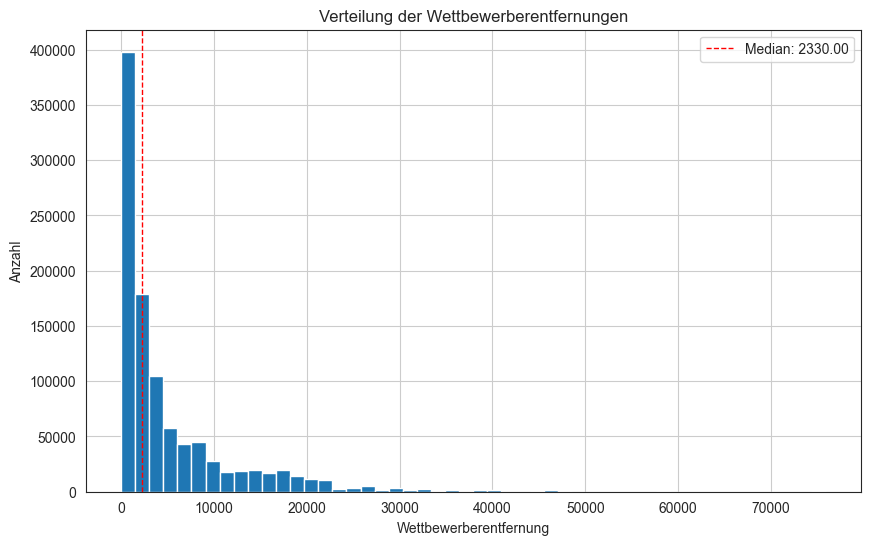

In [264]:
plt.figure(figsize=(10, 6))
plt.hist(train_x_store["Wettbewerberentfernung"], bins=50, edgecolor='white')
plt.title('Verteilung der Wettbewerberentfernungen')
plt.xlabel('Wettbewerberentfernung')
plt.ylabel('Anzahl')

median = train_x_store["Wettbewerberentfernung"].median()

plt.axvline(median, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median:.2f}')

plt.legend()
plt.grid(True)

Wir nehmen  an, dass die Daten einfach nicht vorhanden sind und ersetzen daher die fehlenden Werte in _Wettbewerberentfernung_ mit dem Median.
Warum Median?
-  Robustheit gegenüber Ausreißern: Der Median ist weniger anfällig für Ausreißer im Vergleich zum arithmetischen Mittelwert
- Verteilung der Daten: Wenn die Verteilung der Daten nicht symmetrisch ist oder nicht normal verteilt ist, kann der Median oft die zentrale Tendenz der Daten besser widerspiegeln als der Mittelwert. Dies ist häufig der Fall bei Daten, die rechtsschief oder linksschief verteilt sind.
- Der Median ist ein besserer Indikator für die zentrale Tendenz der Daten, insbesondere wenn man bedenkt, dass die Standardabweichung (7.706,913) relativ hoch ist. Dies deutet darauf hin, dass die Daten möglicherweise eine gewisse Varianz oder Ausreißer aufweisen könnten, die den Mittelwert verzerren würden.

In [221]:
train_x_store["Wettbewerberentfernung"].fillna(train_x_store["Wettbewerberentfernung"].median(), inplace=True)

#### Fehlende Werte in _Wettbewerber_Eroeffnet_seit_Monat_ und _Wettbewerber_Eroeffnet_seit_Jahr_

#### Fehlende Werte in Teilnahme_Langzeitaktion, Aktion_seit_Woche, Aktion_seit_Jahr

Als nächstes sehen wir uns die Spalten _Teilnahme_Langzeitaktion_, _Aktion_seit_Woche_ und _Aktion_seit_Jahr_ an. Sofern eine Filiale an einer Langzeitaktion teilnimmt, sollten auch Monat und Jahr nicht fehlen.

In [192]:
display(train_x_store[(train_x_store.Teilnahme_Langzeitaktion==1) & (pd.isnull(train_x_store.Aktion_seit_Woche))])
display(train_x_store[(train_x_store.Teilnahme_Langzeitaktion==1) & (pd.isnull(train_x_store.Aktion_seit_Jahr))])

,Filiale,Tag,Monat,Jahr,Quartal,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate


,Filiale,Tag,Monat,Jahr,Quartal,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate


Immer wenn eine Filiale an der Langzeitaktion teilnimmt, fehlen keine Wochen oder Jahre. Daher können wir bei keiner Teilnahme an Langzeitaktionen die fehlenden Werte durch Null ersetzen.

In [193]:
train_x_store["Aktion_seit_Woche"].fillna(0, inplace=True)
train_x_store["Aktion_seit_Jahr"].fillna(0, inplace=True)

### 3.6 Ausreißer <a id="3.6"></a> <br>

#### Tage ohne Umsatz betrachten

Gibt es Datensätze mit 0€ Umsatz? Wenn ja, wann und wieso ist das so?

In [194]:
display(train_x_store[train_x_store.Umsatz==0.0])

kein_umsatz_anzahl = train_x_store[train_x_store.Umsatz==0.0].shape[0]

print(str(kein_umsatz_anzahl) + " von " + str(train_x_store.shape[0]) + " Zeilen (" + str(round(kein_umsatz_anzahl/train_x_store.shape[0]*100,2)) + "%) haben keinen Umsatz.")


,Filiale,Tag,Monat,Jahr,Quartal,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate
5,1,26,7,2015,3,6,2015-07-26,0,0,0,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN
12,1,19,7,2015,3,6,2015-07-19,0,0,0,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN
19,1,12,7,2015,3,6,2015-07-12,0,0,0,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN
26,1,5,7,2015,3,6,2015-07-05,0,0,0,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN
33,1,28,6,2015,2,6,2015-06-28,0,0,0,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017182,1115,27,1,2013,1,6,2013-01-27,0,0,0,0,0,0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017189,1115,20,1,2013,1,6,2013-01-20,0,0,0,0,0,0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017196,1115,13,1,2013,1,6,2013-01-13,0,0,0,0,0,0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017203,1115,6,1,2013,1,6,2013-01-06,0,0,0,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


172871 von 1017209 Zeilen (16.99%) haben keinen Umsatz.


Wir nehmen uns eine zufällige Filiale und schauen uns an, wann kein Umsatz gemacht wurde

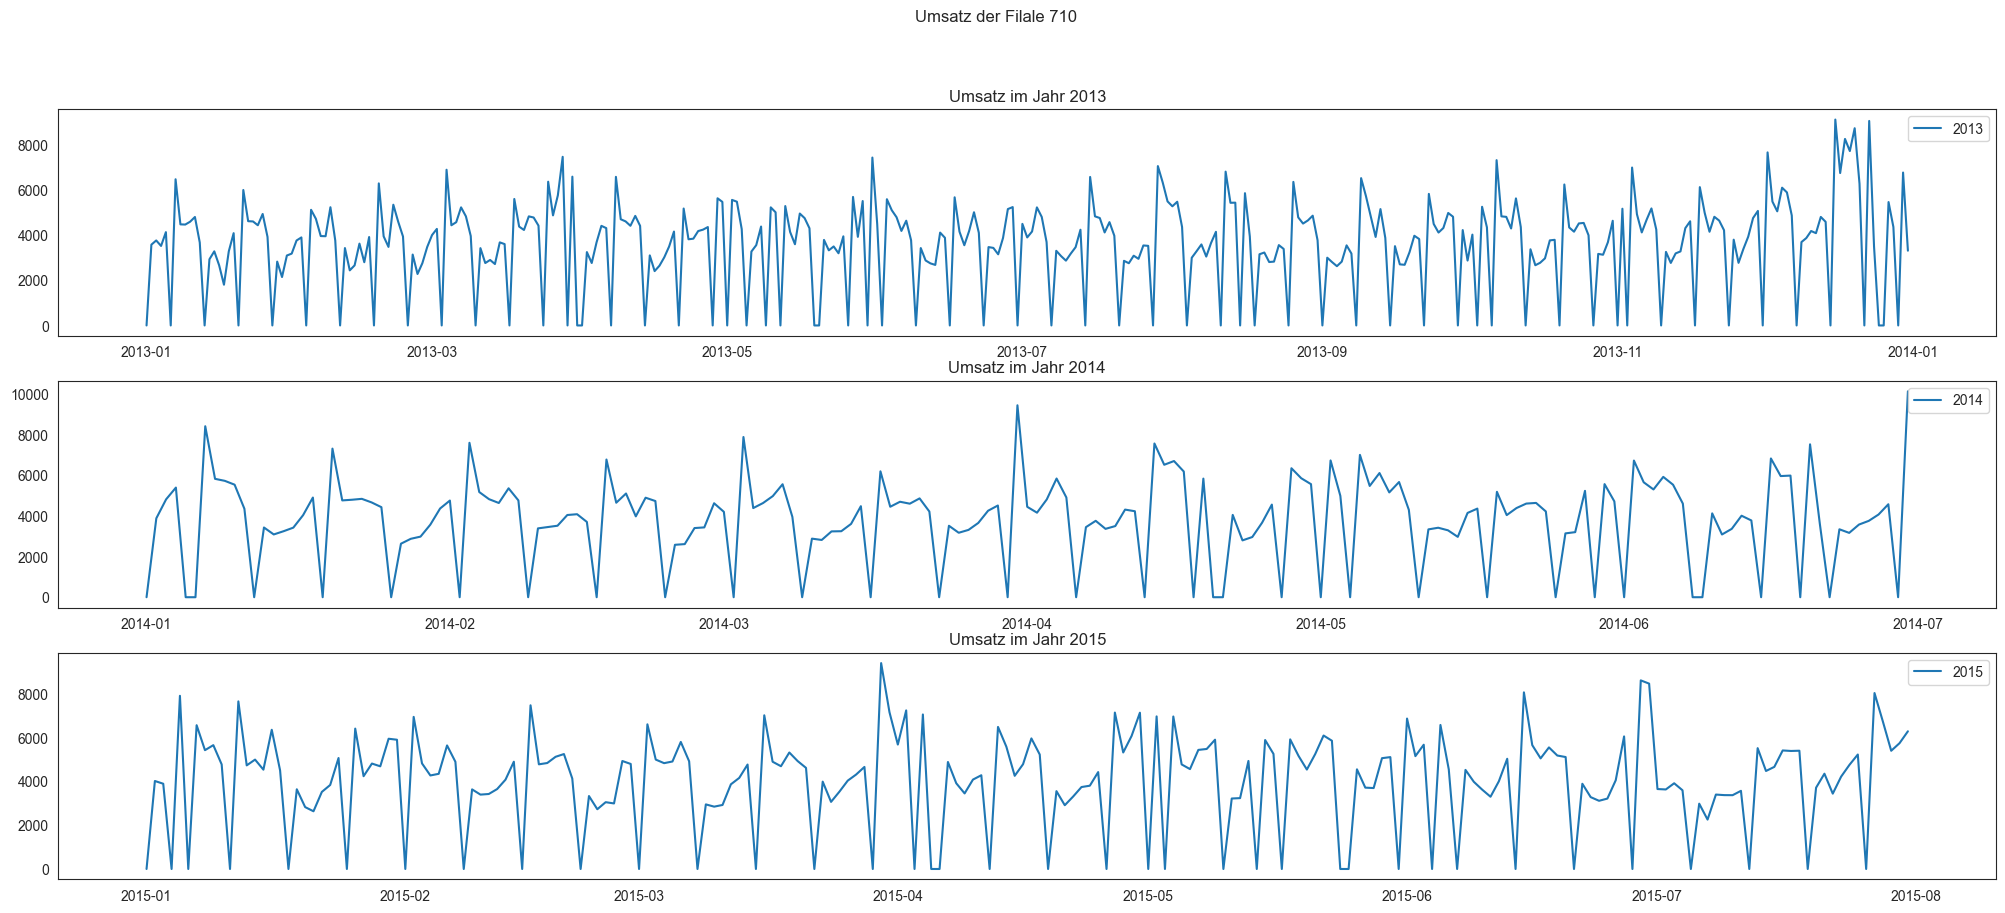

In [195]:
store_id = store["Filiale"].sample(n=1).values[0]
sample = train_x_store[train_x_store["Filiale"]==store_id].copy()
gp_sample_by_year = sample.groupby(sample["Datum"].dt.year)

fig, axs = plt.subplots(3)
fig.set(figheight = 10, figwidth = 25)
fig.suptitle(f"Umsatz der Filale {store_id}")

for id, sample_year in enumerate(gp_sample_by_year):
    axs[id].plot(sample_year[1]["Datum"], sample_year[1]["Umsatz"], label = sample_year[0])
    axs[id].set_title(f"Umsatz im Jahr {sample_year[0]}")
    axs[id].legend()

plt.show()

In [196]:
# Alle Tage, an denen kein Umsatz gemacht wurde, obwohl die Filiale geöffnet war
kein_umsatz_geoeffnet = train[(train["Umsatz"]==0) & (train["Geoeffnet"]==True)]
kein_umsatz_geoeffnet.head()

,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien
86825,971,5,2015-05-15,0,0,1,0,0,1
142278,674,4,2015-03-26,0,0,1,0,0,0
196938,699,4,2015-02-05,0,0,1,1,0,0
322053,708,3,2014-10-01,0,0,1,1,0,0
330176,357,1,2014-09-22,0,0,1,0,0,0


In [197]:
kein_umsatz_geoeffnet_grouped = kein_umsatz_geoeffnet.groupby(["Wochentag", "Geoeffnet"]).agg(
    Anzahl_Tage=('Umsatz', 'size'),   # Anzahl der Zeilen
    Umsatz=('Umsatz', 'sum')     # Summe der Umsätze
)

kein_umsatz_geoeffnet_grouped

,,Anzahl_Tage,Umsatz
Wochentag,Geoeffnet,,
1,1,3,0
2,1,6,0
3,1,14,0
4,1,18,0
5,1,7,0
6,1,6,0


#### Leere Werte betrachten

- Häufigkeitsverteilungen: Anzahl der Vorkommen jeder Kategorie (z.B. Anzahl der Filialen, Wochentage, Promotion-Typen).
- Balkendiagramme: Grafische Darstellung der Häufigkeiten.

### 3.7 Zeitreihenanalyse <a id="3.7"></a> <br>

- Trendanalyse: Darstellung des Umsatzes über die Zeit, um Trends, saisonale Muster oder Zyklen zu identifizieren.
- Saisonale Muster: Analyse von Wochen-, Monats- und Jahresmustern.

In [198]:
# choose random store (id)
store_id = train_x_store["Filiale"].sample(n=1).values[0]
# store_id = 200

"""
get a sample of the training data 
Sample includes all data of the selected store (id)
"""
sample = train_x_store[train_x_store["Filiale"]==store_id].copy()
sample["Datum"] = pd.to_datetime(sample["Datum"])
sample.set_index("Datum", inplace = True, drop = True)
sample.sort_index(inplace = True)

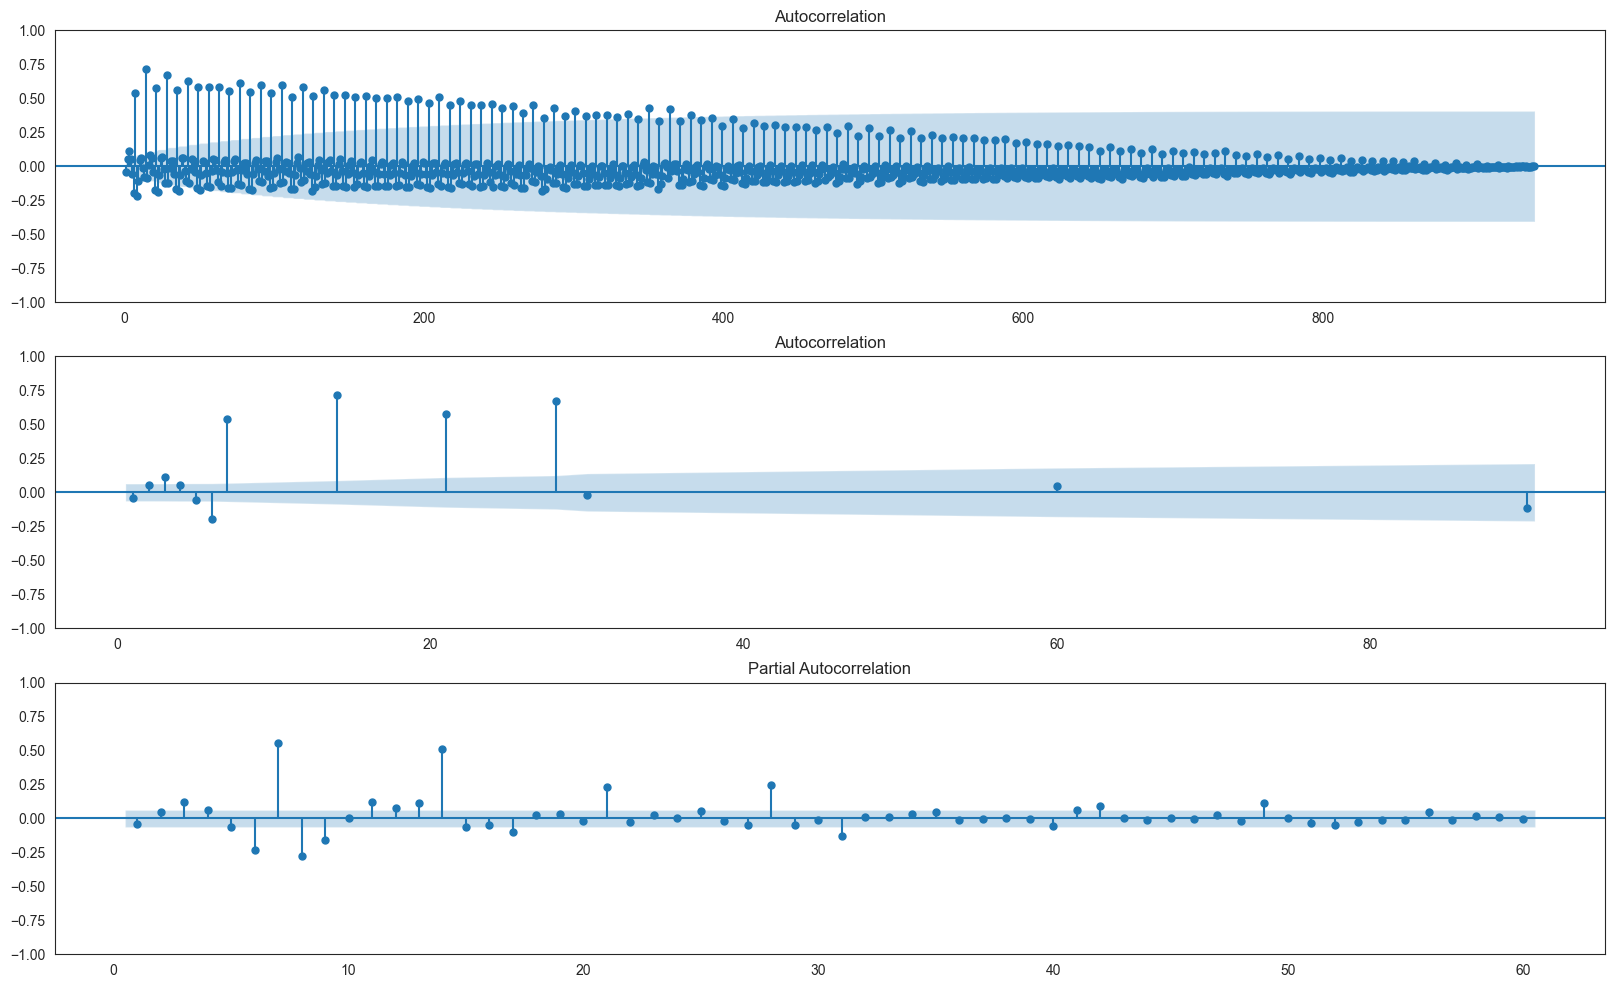

In [199]:
# display(sample)
lags = [1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 30, 60, 90]

fig, axs = plt.subplots(3, figsize= (20,12))
plot_acf(sample["Umsatz"], lags = len(sample)-1, zero = False, ax = axs[0])
plot_acf(sample["Umsatz"], lags = lags, zero = False, ax = axs[1])
plot_pacf(sample["Umsatz"], lags = 60, zero = False, ax = axs[2])

plt.show()

Der Umsatz weist eine Autokorrelation zu den Vielfachen von Sieben auf, was darauf schließen lässt, dass der Umsatz vom Wochentag abhängig ist. Die Autokorrelation gibt keinen Hinweis auf einen anderen zeitlichen Einfluss. Im Folgenden wird der zeitliche Einfluss der Woche als Saisonalität aus den Daten herausgerechnet und so der Einfluss der Saisonalität dargestellt. Aufgrund der Ergebnisse der Untersuchung der Autokorrelation wird als Periode (Dauer einer Saisonalität) 7 gewählt. 

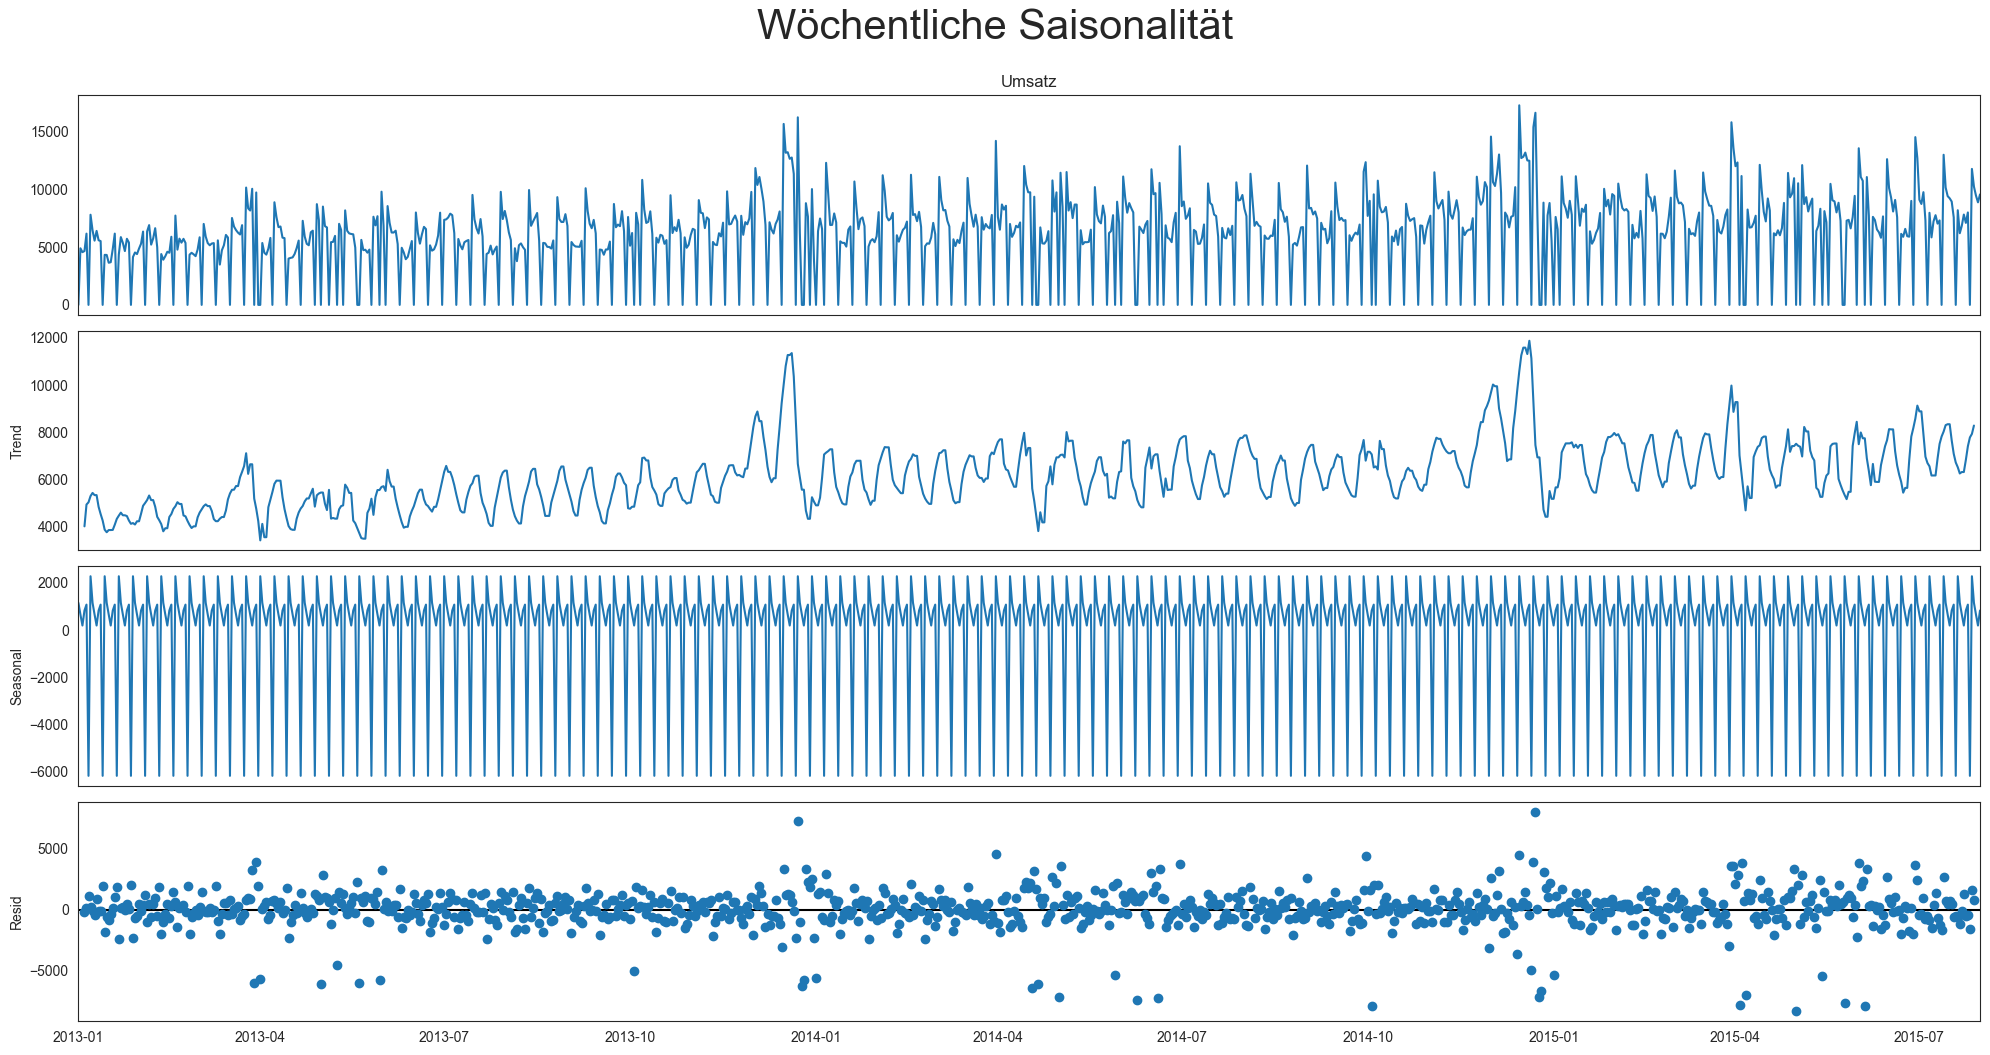

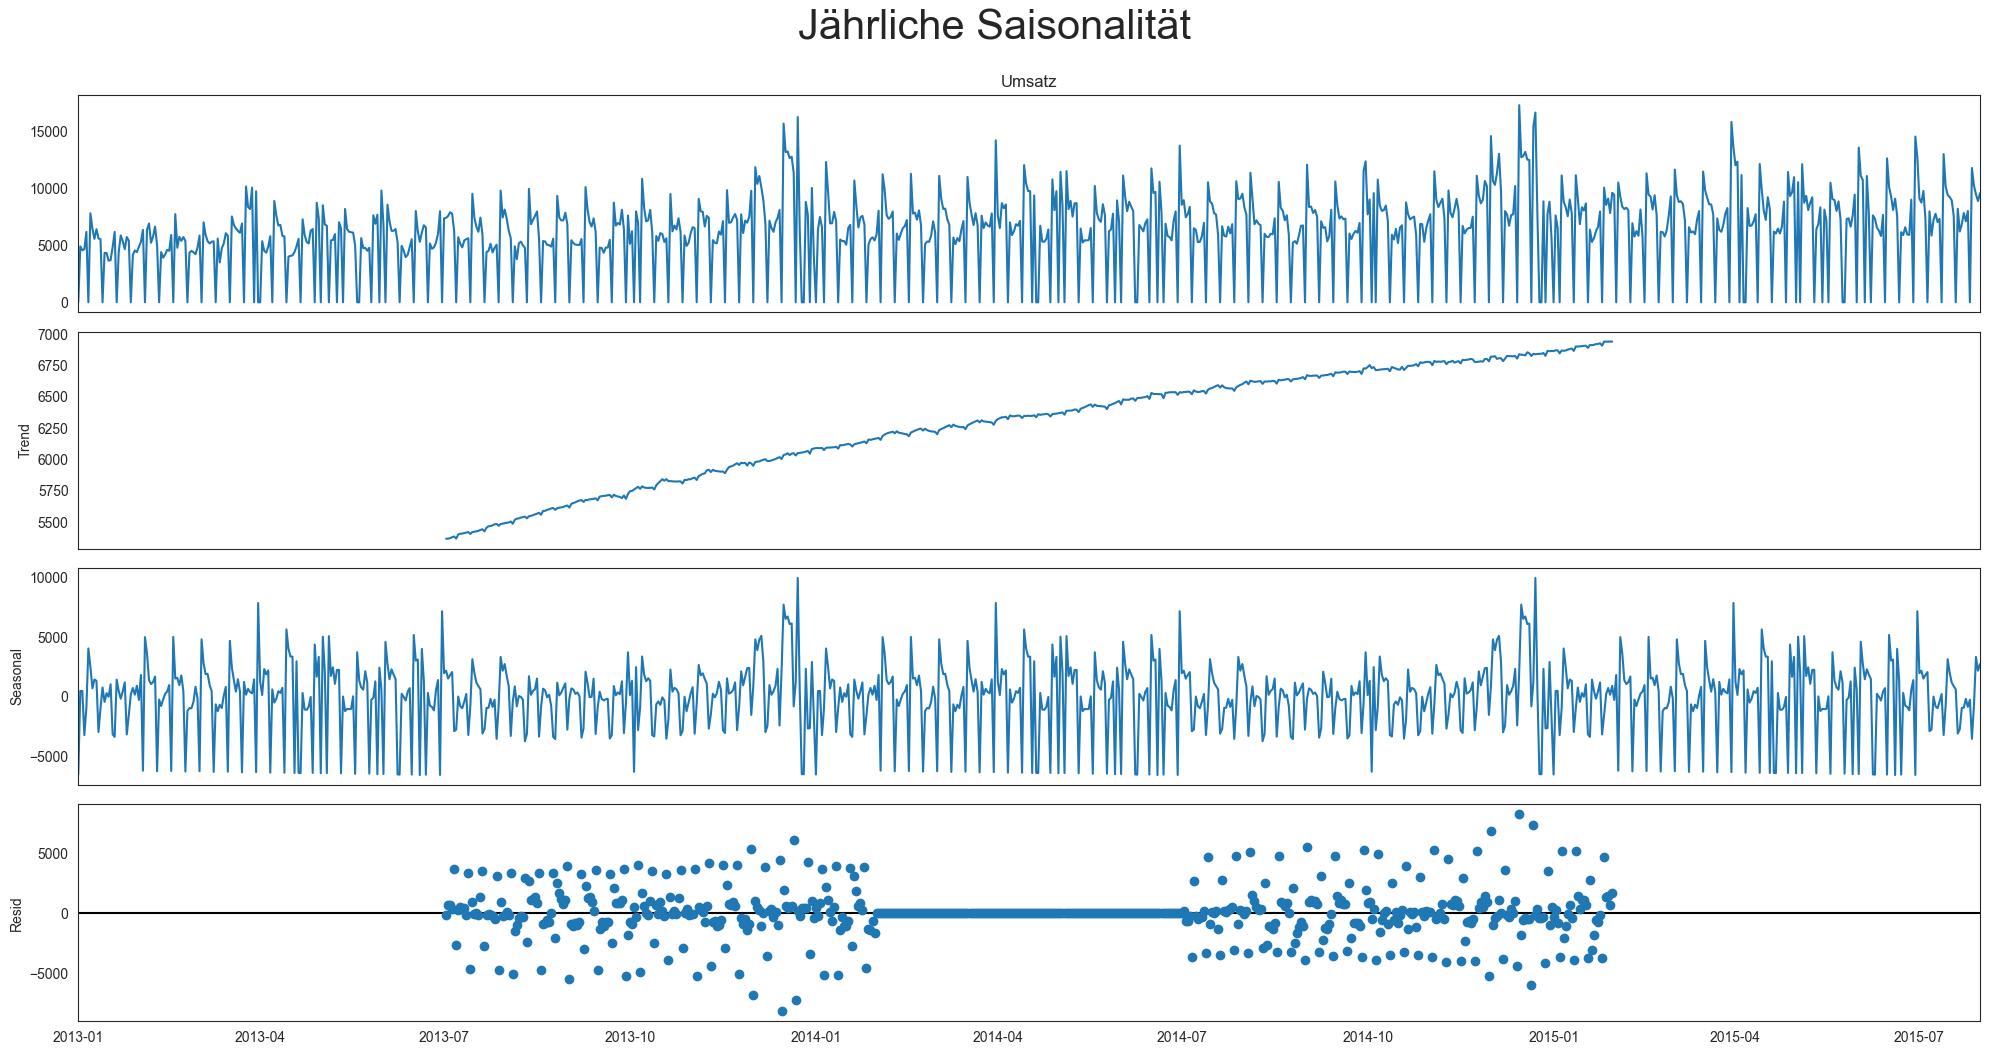

In [200]:
stl_weekly_umsatz = seasonal_decompose(sample["Umsatz"], model = "additive", period = 7)
stl_yearly_umsatz = seasonal_decompose(sample["Umsatz"], model = "additive", period = 365)

plt.rcParams.update({'figure.figsize': (20, 10)})
stl_weekly_umsatz.plot().suptitle('Wöchentliche Saisonalität', fontsize=30, y=1.05)
stl_yearly_umsatz.plot().suptitle('Jährliche Saisonalität', fontsize=30, y=1.05)
plt.show()

Bei der Zerlegung des Umsatzes in einen Wiederkehrenden Term (Saisonalität - Seasonal), einen den zugrunden liegenden Trend und einen unerklärlichen Teil (Residuen - Resid) ergeben sich, bei einer Periodenlänge von 7 bzw. 365 Tagen die oberen Plots. Auch wenn die Autokorrelation keinen Hinweis auf weitere zeitliche Einflüsse als die Woche (den Wochentag) gegeben hat, weist der Trend markante und wiederkehrende Erhebungen auf, die auf eine weitere Saisonalität hindeuten. 

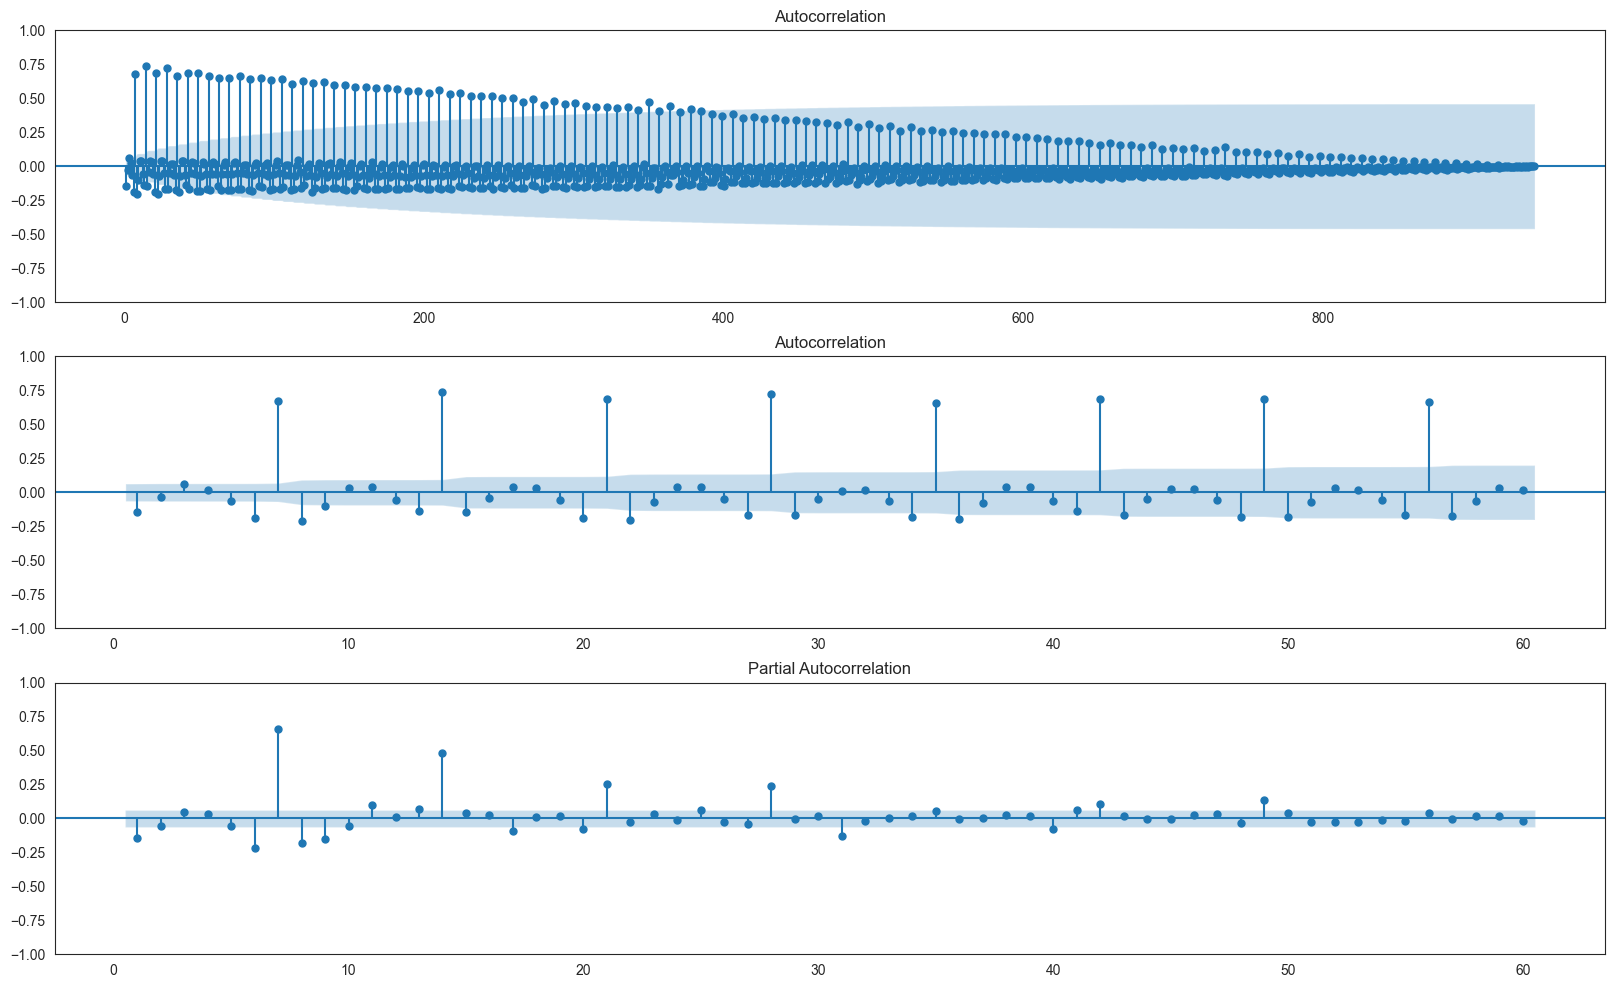

In [201]:
fig, axs = plt.subplots(3, figsize= (20,12))
plot_acf(sample["Kundenanzahl"], lags = len(sample)-1, zero = False, ax = axs[0])
plot_acf(sample["Kundenanzahl"], lags = 60, zero = False, ax = axs[1])
plot_pacf(sample["Kundenanzahl"], lags = 60, zero = False, ax = axs[2])

plt.show()

Die Kundenanzahl weist eine Autokorrelation zu den Vielfachen von Sieben auf, was darauf schließen lässt, dass die Kundenanzahl vom Wochentag abhängig ist. Die Autokorrelation gibt keinen Hinweis auf einen anderen zeitlichen Einfluss. Im Folgenden wird der zeitliche Einfluss der Woche als Saisonalität aus den Daten herausgerechnet und so der Einfluss der Saisonalität dargestellt. Aufgrund der Ergebnisse der Untersuchung der Autokorrelation wird als Periode (Dauer einer Saisonalität) 7 gewählt. 

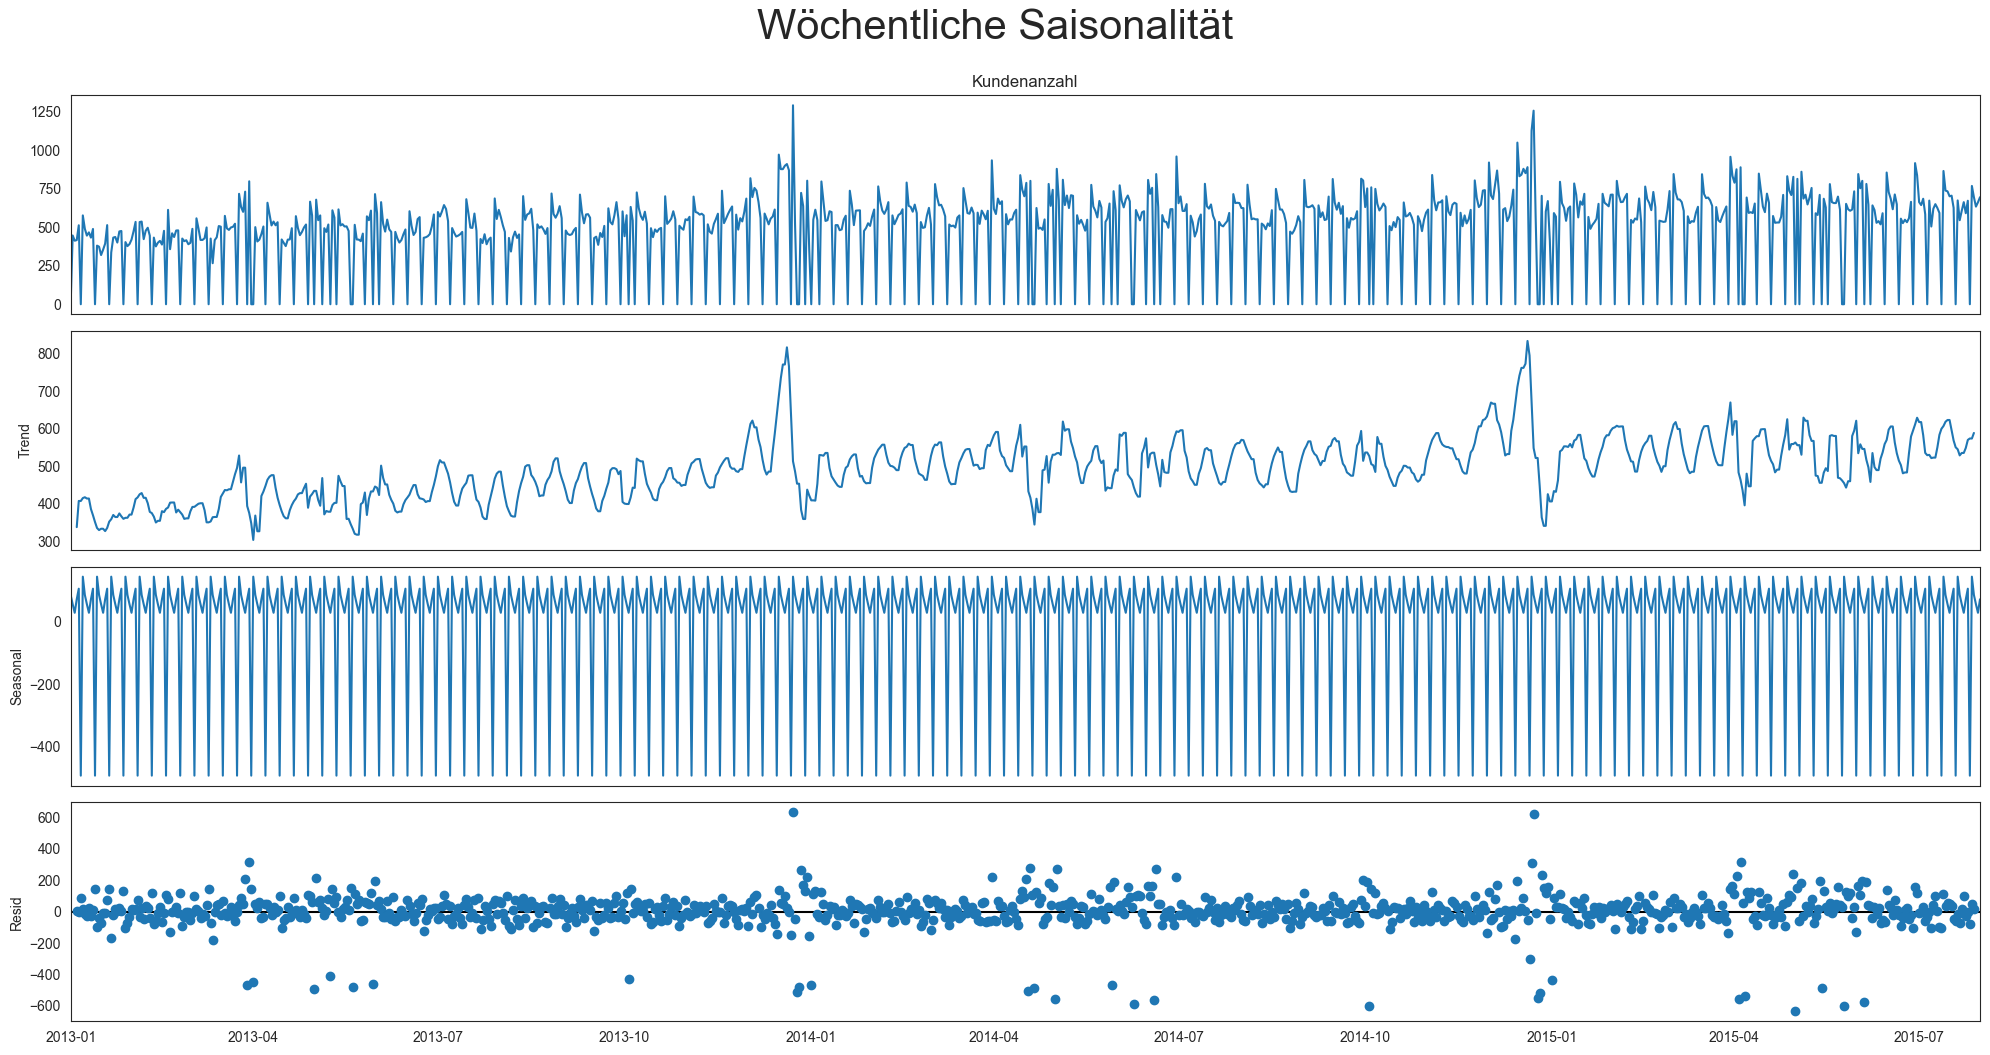

In [202]:
stl_weekly_kundenzahl = seasonal_decompose(sample["Kundenanzahl"], model = "additive", period=7)

plt.rcParams.update({'figure.figsize': (20, 10)})
stl_weekly_kundenzahl.plot().suptitle('Wöchentliche Saisonalität', fontsize=30, y=1.05)

plt.show()

Bei der Zerlegung der Kundenanzahl in einen Wiederkehrenden Term (Saisonalität - Seasonal), einen den zugrunden liegenden Trend und einen unerklärlichen Teil (Residuen - Resid) ergeben sich, bei einer Periodenlänge von 7 bzw. 365 Tagen die oberen Plots. Auch wenn die Autokorrelation keinen Hinweis auf weitere zeitliche Einflüsse als die Woche (den Wochentag) gegeben hat, besitzt der Trend markante und wiederkehrende Erhebungen, die auf eine weitere Saisonalität hindeuten. 

In [203]:
sample_gp_weekday = sample.groupby(by=["Wochentag"])

weekdays = []
mean_revenue = []
mean_numb_of_customers = []
for weekday, df in sample_gp_weekday:
    weekdays.append(weekday[0])
    mean_revenue.append(df["Umsatz"].mean())
    mean_numb_of_customers.append(df["Kundenanzahl"].mean())
    

df_avg_week = pd.DataFrame(data = {"Wochentag": weekdays, "Umsatz": mean_revenue, "Kundenanzahl": mean_numb_of_customers})
display(df_avg_week)

,Wochentag,Umsatz,Kundenanzahl
0,0,8467.014925,638.074627
1,1,7290.666667,575.422222
2,2,6841.792593,549.370370
3,3,6375.407407,522.259259
4,4,7012.985185,565.340741
5,5,7255.253731,599.044776
6,6,0.000000,0.000000


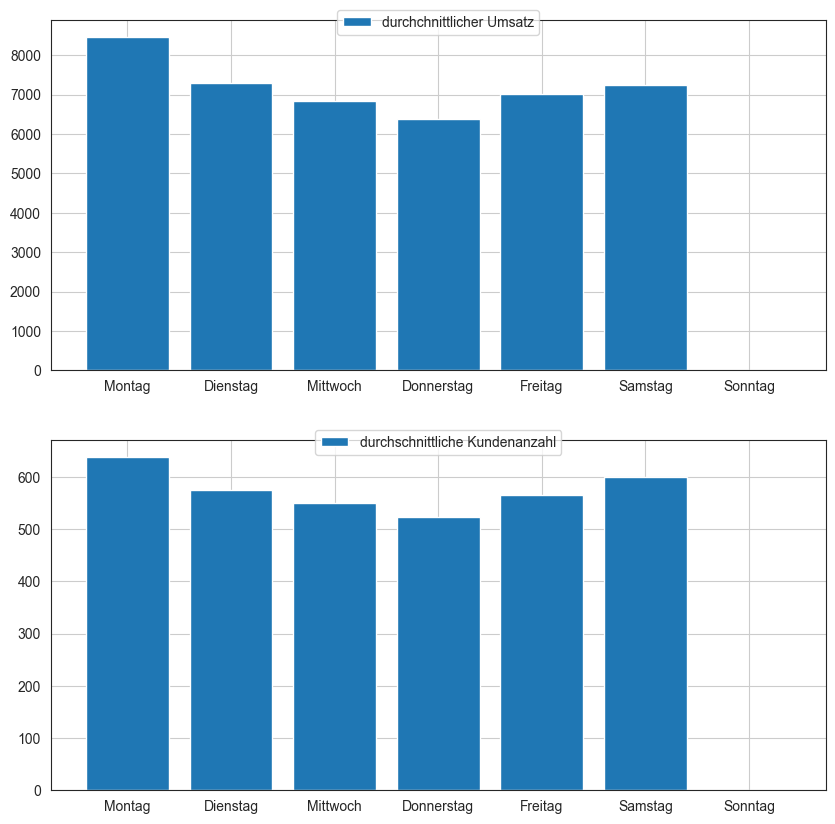

In [204]:
locale.setlocale(locale.LC_ALL, 'de_DE')

fig, axs = plt.subplots(2, figsize = (10,10))

axs[0].bar(calendar.day_name, df_avg_week.Umsatz, label = "durchchnittlicher Umsatz")
axs[1].bar(calendar.day_name, df_avg_week.Kundenanzahl, label = "durchschnittliche Kundenanzahl")

for ax in axs:
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))
    ax.grid()
plt.show()


In [205]:
sample_gp_day = sample.groupby(by=["Tag"])

days = []
mean_revenue = []
mean_numb_of_customers = []
for day, df in sample_gp_day:
    days.append(day[0])
    mean_revenue.append(df["Umsatz"].mean())
    mean_numb_of_customers.append(df["Kundenanzahl"].mean())
    

df_avg_day_of_month = pd.DataFrame(data = {"Tag": days, "Umsatz": mean_revenue, "Kundenanzahl": mean_numb_of_customers})
display(df_avg_day_of_month.head(3))

,Tag,Umsatz,Kundenanzahl
0,1,5128.967742,384.032258
1,2,7340.677419,570.290323
2,3,6228.741935,473.322581


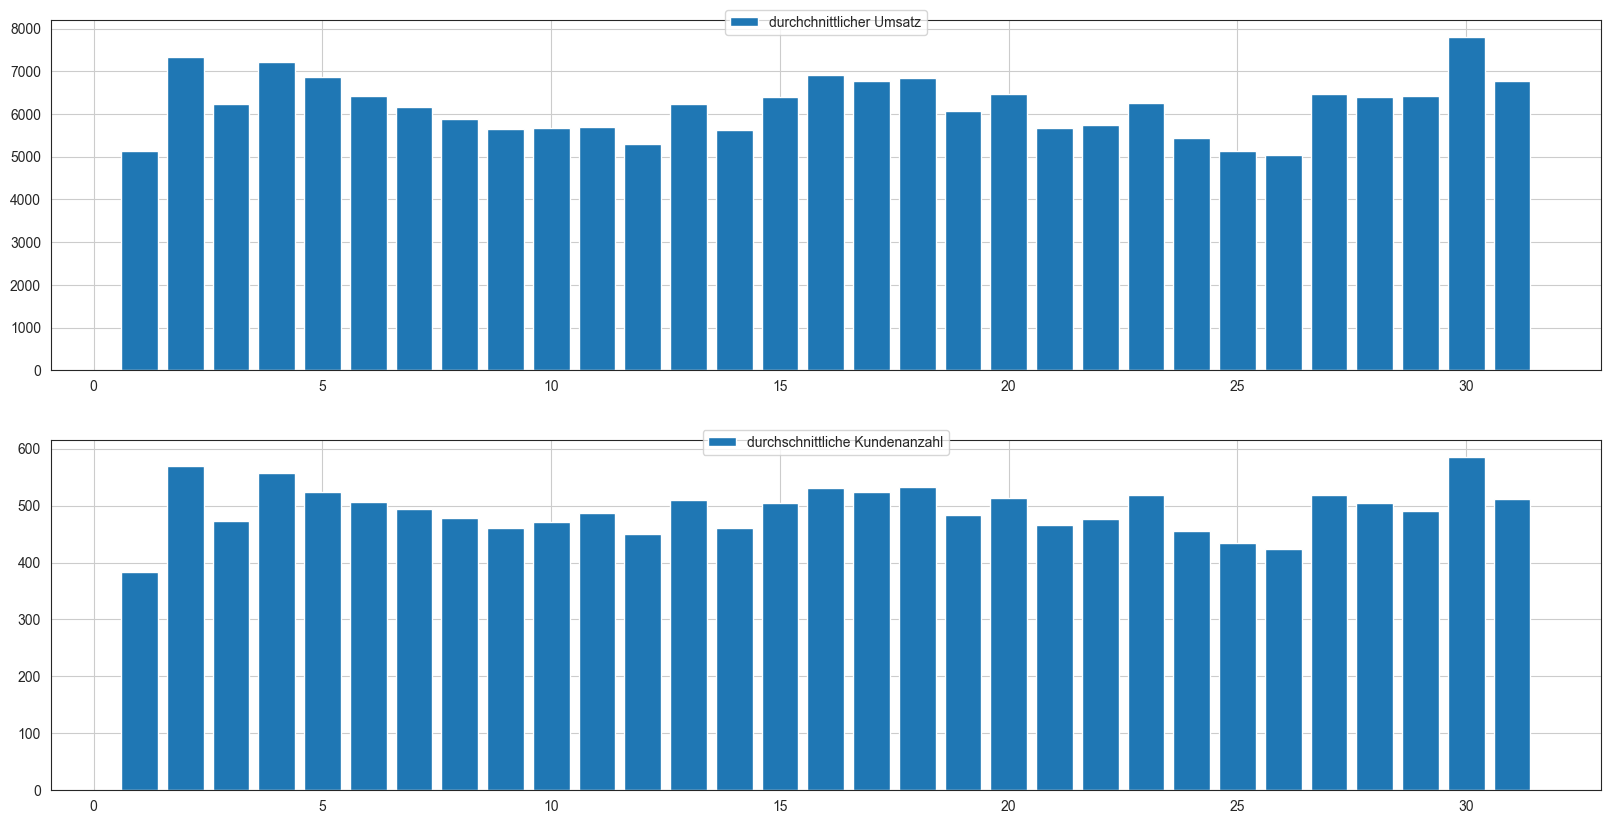

In [206]:
fig, axs = plt.subplots(2, figsize = (20,10))

axs[0].bar(df_avg_day_of_month.Tag, df_avg_day_of_month.Umsatz, label = "durchchnittlicher Umsatz")
axs[1].bar(df_avg_day_of_month.Tag, df_avg_day_of_month.Kundenanzahl, label = "durchschnittliche Kundenanzahl")

for ax in axs:
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))
    ax.grid()
plt.show()

### 3.8 Korrelationsanalyse <a id="3.8"></a> <br>

#### Korrelationsmatrix auf den gesamten Train-Store-Datensatz

Die Korrelationsmatrix beinhaltet alle numerischen Spalten aus dem _train_x_store_ Datensatz. Dabei wird bei der Pearson-Korrelation mit binären Variablen genauso wie mit kontinuierlichen Variablen umgegangen.

,Filiale,Tag,Monat,Jahr,Quartal,Wochentag,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Schulferien,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr
Filiale,1.000000,0.000023,0.001467,0.000290,0.001491,-0.000008,0.005126,0.024325,-0.000047,0.000058,0.000641,-0.026451,-0.050746,-0.004592,0.008488,0.011053,0.008520
Tag,0.000023,1.000000,0.012442,-0.002485,0.014186,0.005136,-0.011612,-0.004473,0.033428,-0.108325,0.030538,0.000049,-0.000006,0.000056,-0.000354,-0.000435,-0.000354
Monat,0.001467,0.012442,1.000000,-0.269382,0.968723,-0.005362,0.048768,0.038179,-0.000681,-0.011747,0.103282,0.003614,-0.000624,0.003916,-0.025323,-0.031188,-0.025329
Jahr,0.000290,-0.002485,-0.269382,1.000000,-0.260642,0.001937,0.023519,-0.001212,-0.001009,0.024300,-0.036535,0.000710,-0.000121,0.000771,-0.004982,-0.006135,-0.004983
Quartal,0.001491,0.014186,0.968723,-0.260642,1.000000,-0.008071,0.043984,0.036096,0.003561,-0.007293,0.148667,0.003672,-0.000634,0.003979,-0.025734,-0.031694,-0.025740


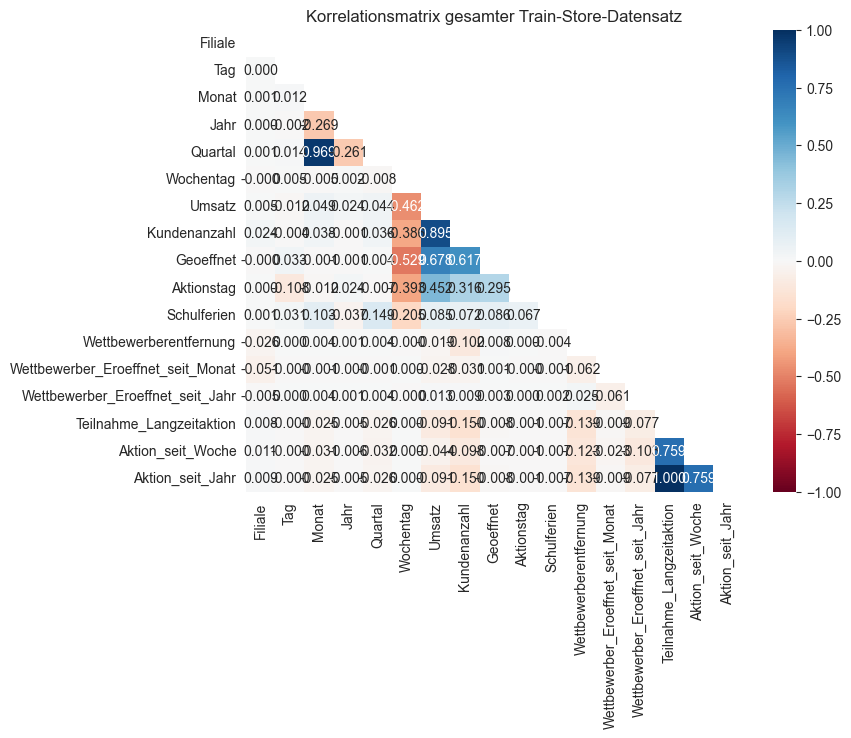

In [207]:
# Spalten mit numerischen Werten (Strings und kategorische Werte ausgeschlossen)
train_x_store_only_nr = train_x_store.select_dtypes(include=['number'])

# Korrelationsmatrix nach Pearson-Verfahren erstellen
corr_matrix_all = train_x_store_only_nr.corr("pearson")
display(corr_matrix_all.head())

# Nur unteres Dreieck in der Korrelationsmatrix ziehen
my_mask = np.triu(np.ones_like(corr_matrix_all, dtype=bool))

# Korrelationsmatrix erstellen und formatieren
plt.figure(figsize=(8,6))
plot = sns.heatmap(corr_matrix_all, cmap="RdBu", vmin=-1, vmax=1, annot=True, fmt="0.3f", mask=my_mask)
plot.set_title("Korrelationsmatrix gesamter Train-Store-Datensatz")
plt.show()

#### Korrelationsmatrix einer zufälligen Filiale des Train-Store-Datensatzes

In [208]:
# Eine Filiale zufällig wählen
store_id = store["Filiale"].sample(n=1).values[0]

# Den Datensatz auf die zuvor festgelegte Filiale filtern
sample = train_x_store[train_x_store["Filiale"]==store_id].copy()

# Spalten mit numerischen Werten (Strings und kategorische Werte ausgeschlossen)
sample_only_nr = sample.select_dtypes(include=['number'])

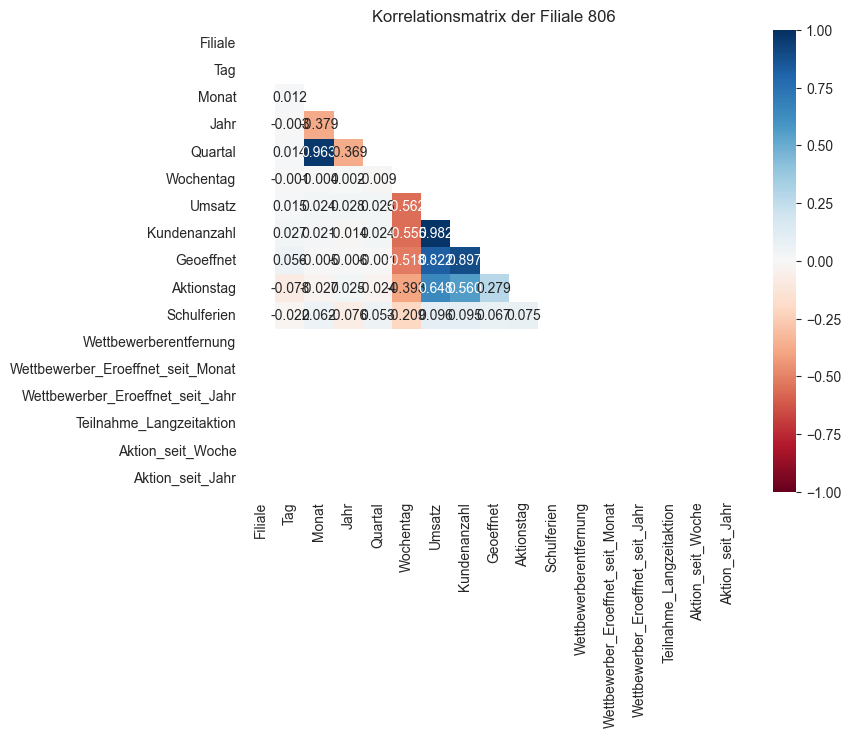

In [209]:
# Korrelationsmatrix nach Pearson-Verfahren erstellen
corr_matrix_sample = sample_only_nr.corr("pearson")

# Nur unteres Dreieck in der Korrelationsmatrix ziehen
my_mask = np.triu(np.ones_like(corr_matrix_sample, dtype=bool))

# Korrelationsmatrix erstellen und formatieren
plt.figure(figsize=(8,6))
plot = sns.heatmap(corr_matrix_sample, cmap="RdBu", vmin=-1, vmax=1, annot=True, fmt="0.3f", mask=my_mask)
plot.set_title(f"Korrelationsmatrix der Filiale {store_id}")
plt.show()

Die Korrelationsmatrix weist einen großen weißen Bereich mit NaN-Werten auf, da diese Spalten konstante Werte enthalten. In solchen Fällen ist die Standardabweichung gleich null, was zur Folge hat, dass die Berechnung der Korrelation nicht möglich ist.

#### Korrelationsmatritzen miteinander vergleichen

- Positive Werte zeigen an, dass der Korrelationskoeffizient in der ersten Matrix größer ist als in der zweiten Matrix.
- Negative Werte zeigen an, dass der Korrelationskoeffizient in der zweiten Matrix größer ist als in der ersten Matrix.
- Ein Wert von Null in der Differenzmatrix bedeutet, dass sich die Korrelationskoeffizienten zwischen den beiden Matrizen nicht unterscheiden, d.h., die Korrelationen sind für diese Variablenpaare gleich.

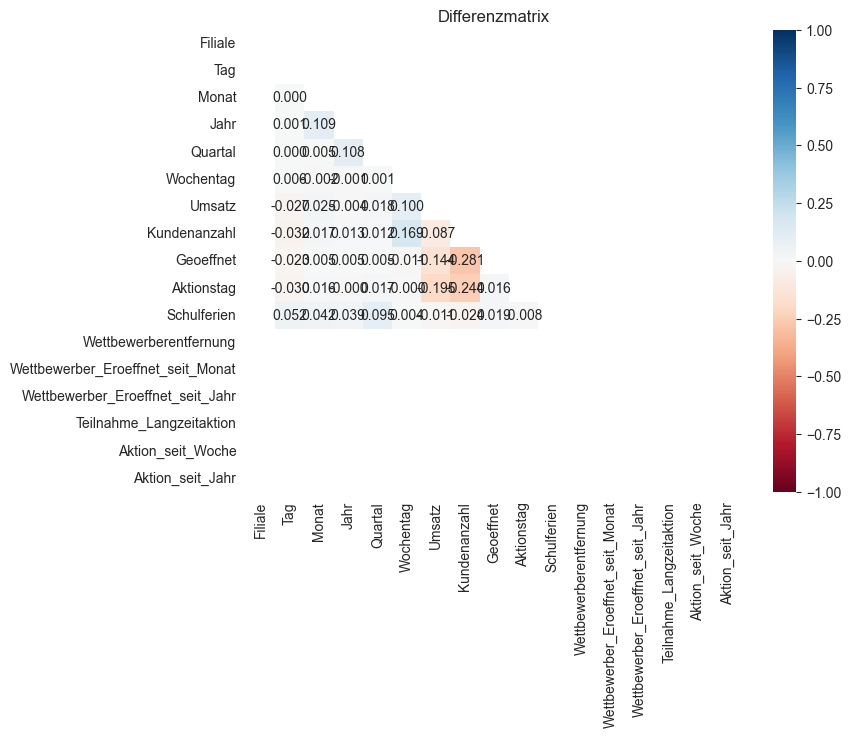

In [210]:
# Differenz der beiden Korrelationsmatritzen nach Pearson-Verfahren erstellen
diff_matrix = corr_matrix_all - corr_matrix_sample

# Nur unteres Dreieck in der Korrelationsmatrix ziehen
my_mask = np.triu(np.ones_like(diff_matrix, dtype=bool))

# Korrelationsmatrix erstellen und formatieren
plt.figure(figsize=(8,6))
plot = sns.heatmap(diff_matrix, cmap="RdBu", vmin=-1, vmax=1, annot=True, fmt="0.3f", mask=my_mask)
plot.set_title("Differenzmatrix")
plt.show()


## Geeignete Merkmale <a id="4"></a> <br>

Definieren Sie geeignete Merkmale (Features) für die Klassifikation/Regression/Clustering. Versuchen Sie dabei, aus den bestehenden Merkmale neue abzuleiten und überlegen Sie sich zusätzliche z.B. mit externen Informationen. 

## Machine Learning Verfahren 1 <a id="5"></a> <br>

### 5.1 XXX <a id="5.1"></a> <br>

### 5.2 Modellgüte <a id="5.2"></a> <br>

## Machine Learning Verfahren 2 <a id="6"></a> <br>

## Vergleich der Machine Learning Verfahren <a id="7"></a> <br>